# Data mining HW3

author: Ali ArjomandBigdeli (Student Number: 9423008)

## Question 1: Classification of [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database) using Linear regression(implementation)

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read dataset
df = pd.read_csv('./Data/1/diabetes.csv')
train_dataset = df.iloc[:, 0:df.shape[1]-1].values
y_star = df['Outcome'].values

In [3]:
# weight matrix
lam = 0.0001 # Lambda
phiT_phi = train_dataset.transpose() @ train_dataset
weight_mat = np.dot(np.linalg.inv(phiT_phi + lam * np.identity(train_dataset.shape[1])) @ train_dataset.transpose(), y_star)

In [4]:
# prediction
y_predict = np.dot(train_dataset, weight_mat)
y_predict = .5 * np.sign(y_predict - .5) + .5
y_predict = y_predict.astype(int)

In [5]:
# evalution
accuracy = 1 - np.sum(np.abs(y_predict - y_star)) / len(train_dataset)
print(f"accuracy: {accuracy * 100} %")

accuracy: 75.65104166666666 %


## Question 2: ["Quora Insincere Questions Classification"](https://www.kaggle.com/c/quora-insincere-questions-classification/data) using naive bayes

In [6]:
# read data
train = pd.read_csv('./Data/2/train.csv')
test = pd.read_csv('./Data/2/test.csv')
print(train.shape,test.shape)

(1306122, 3) (375806, 2)


In [7]:
# check null values
print(f"null values: {train.isnull().sum()}")

null values: qid              0
question_text    0
target           0
dtype: int64


In [8]:
# data preprocessing
import re
import string
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def prepare_for_char_n_gram(text):
    clean = bytes(text.lower(), encoding="utf-8")
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    tokens = clean.split()
    tokens_r = [word for word in tokens if word not in stop_words]
    clean = b" ".join([exclude.sub(b'', token) for token in tokens_r])
    clean = re.sub(b"\d+", b" ", clean)
    clean = re.sub(b'\s+', b' ', clean)
    clean = re.sub(b'\s+$', b'', clean)
    clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
    clean = re.sub(b" ", b"# #", clean)  # Replace space
    clean = b"#" + clean + b"#"  # add leading and trailing #
#     data['question_text'] = data['question_text'].apply(cleanHtml)
    return str(clean, 'utf-8')

In [9]:
def remove_stop_words(text):
    words = list(set(prepare_for_char_n_gram(text).split('##')))
    tokens_r = [word for word in words if word not in stop_words]
    clean = ' '.join(tokens_r)
    return clean

In [10]:
train['question_text'] = train['question_text'].apply(cleanHtml).apply(prepare_for_char_n_gram)
test['question_text'] = test['question_text'].apply(cleanHtml).apply(prepare_for_char_n_gram)

In [11]:
train['question_text'] = train['question_text'].apply(remove_stop_words)
test['question_text'] = test['question_text'].apply(remove_stop_words)

In [12]:
# seprate data for validation
from sklearn.model_selection import train_test_split

train, cv = train_test_split(train, test_size=0.2)
x_train = train.drop(['target'],axis=1)
y_train = train['target']
x_cv = cv.drop(['target'],axis=1)
y_cv = cv['target']

In [13]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
reviews_tfidf = tf_idf_vect.fit_transform(x_train['question_text'].values)
reviews_tfidf1 = tf_idf_vect.transform(x_cv['question_text'].values)
reviews_tfidf2 = tf_idf_vect.transform(test['question_text'].values)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    7.8s finished


Train Set Accuracy: 0.9353371672040403
Train Set ROC: 0.7342700247295251
Train Set F1 Score: 0.5889645942328751

Validation Set Accuracy: 0.9295702938080199
Validation Set ROC: 0.7154915966465866
Validation Set F1 Score: 0.5452343286533519

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



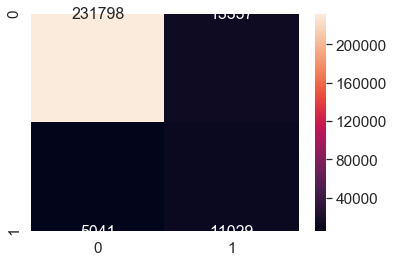

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nb = BernoulliNB()
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001]} #params we need to try on classifier
gsv = GridSearchCV(nb,param_grid,cv=2,verbose=1,n_jobs=-1,scoring='f1')
gsv.fit(reviews_tfidf,y_train)
nb = BernoulliNB(alpha=0.1)
nb.fit(reviews_tfidf,y_train)
train_pred = nb.predict(reviews_tfidf)
cv_pred = nb.predict(reviews_tfidf1)
test_pred = nb.predict(reviews_tfidf2)
print("Train Set Accuracy: {}".format(metrics.accuracy_score(train_pred, y_train)))
print("Train Set ROC: {}".format(metrics.roc_auc_score(train_pred, y_train)))
print("Train Set F1 Score: {}\n".format(metrics.f1_score(train_pred, y_train)))
print("Validation Set Accuracy: {}".format(metrics.accuracy_score(cv_pred, y_cv)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(cv_pred, y_cv)))
print("Validation Set F1 Score: {}\n".format(metrics.f1_score(cv_pred, y_cv)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
# df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
df_cm = pd.DataFrame(confusion_matrix(y_cv, cv_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


In [15]:
#save result to csv
test['prediction'] = test_pred
test = test.drop(['question_text'],axis=1)
test.to_csv("Q2_predict.csv", index=False)

## Question 3: [Predict survival on the Titanic](https://www.kaggle.com/c/titanic)

In [16]:
# Loading data and printing first few rows
train = pd.read_csv('./Data/3/train.csv')
test = pd.read_csv('./Data/3/test.csv')

In [17]:
# check null values

# Retain columns that are of interest and discard the rest (such as Id, Name, Cabin, and Ticket number)
newcols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare','Embarked']
train = train[newcols]
print(f"null values: {train.isnull().sum()}\n")

print("In Training Data missing, columns with missing values:")
# Check which columns have missing data
for column in train.columns:
    if np.any(pd.isnull(train[column])) == True:
        print(column)  

null values: Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In Training Data missing, columns with missing values:
Age
Embarked


In [18]:
# Retain columns that are of interest and discard the rest (such as Id, Name, Cabin, and Ticket number)
newcols = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked']
test = test[newcols]
print(f"null values: {test.isnull().sum()}\n")

print("In Test Data missing, columns with missing values:")
# Check which columns have missing data
for column in test.columns:
    if np.any(pd.isnull(test[column])) == True:
        print(column)  

null values: PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

In Test Data missing, columns with missing values:
Age
Fare


In [19]:
# Filling missing age data with median values
train["Age"] = train["Age"].fillna(train["Age"].median())

# data cleaning for Embarked
print (train["Embarked"].unique())
print (train.Embarked.value_counts())
train["Embarked"] = train["Embarked"].fillna('S')

['S' 'C' 'Q' nan]
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [20]:
# Filling missing age data with median values of trainging set
test["Age"] = test["Age"].fillna(train["Age"].median())

# filling fare data with median of training set
test["Fare"] = test["Fare"].fillna(train["Fare"].median())

In [21]:
for df in [train, test]:
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

def filter_family_size(x):
    if x == 1:
        return 'Solo'
    elif x < 4:
        return 'Small'
    else:
        return 'Big'

for df in [train, test]:
    df['FamilySize'] = df['FamilySize'].apply(filter_family_size)

In [22]:
# matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
plt.rcParams.update({'font.size': 22})

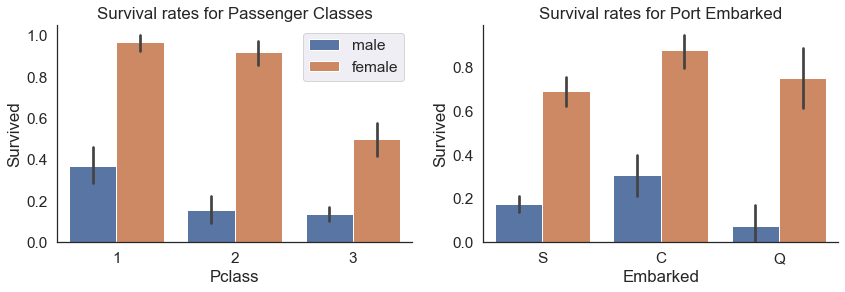

In [23]:
# Check with Pclass and Embarked
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.set_title('Survival rates for Passenger Classes')
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train, ax=ax1)

ax2.set_title('Survival rates for Port Embarked')
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=train, ax=ax2)
sns.despine()
sns.set(font_scale=1.4)
ax2.legend_.remove()
ax1.legend(loc='upper right')
plt.show()

C:\Users\Toshiba\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


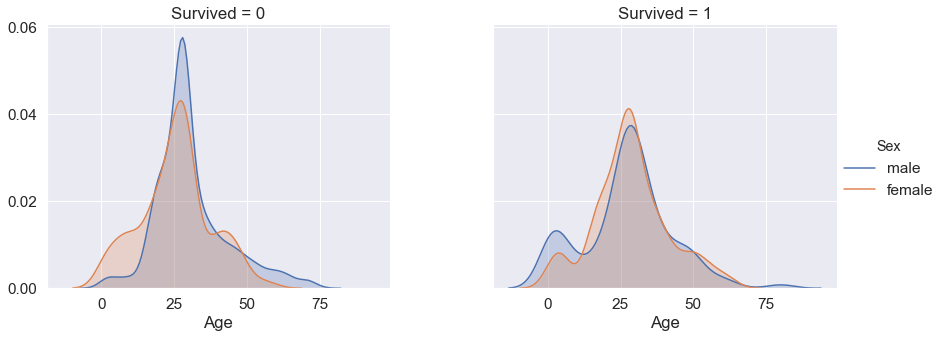

In [24]:
# Check with Age
g = sns.FacetGrid(train, col="Survived", hue='Sex', size=5, aspect = 1.2)
g.map(sns.kdeplot, "Age", shade=True).add_legend().fig.subplots_adjust(wspace=.3)
sns.despine()
sns.set(font_scale=2)
plt.show()

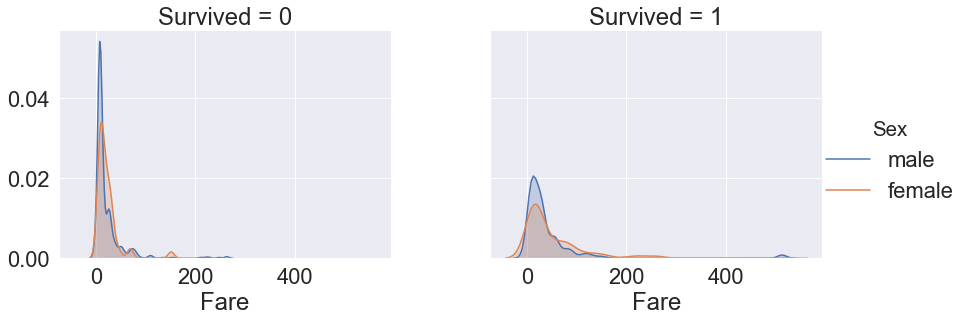

In [25]:
# Check with Fare
g = sns.FacetGrid(train, col="Survived", hue='Sex', size=5, aspect = 1.2)
g.map(sns.kdeplot, "Fare", shade=True).add_legend().fig.subplots_adjust(wspace=.3)
sns.set(font_scale=2)
sns.despine()
plt.show()

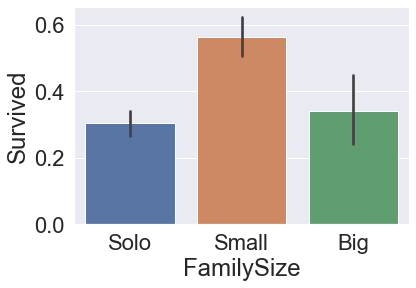

In [26]:
# Family Size
sns.barplot(x='FamilySize', y='Survived' , data=train, order = ['Solo', 'Small', 'Big'])
sns.set(font_scale=1.5)
plt.show()

Key Observations

Sex of passenger: Again there is a strong correlation between the sex and survival, females were certainly given a preference over males.
Passenger Class (pclass): Also correlated with survival, for both males and females, better class has higher survived percentage.
Age: Nothing too striking, however if you look at the distribution for survived population, there is a small peak near lower age(<5 years), seems like childen were also given preference.
Fare: It doesnt have any striking correlation with survival.
Family Size: It seems that small family sizes did better than larger families as well as solo travellers.

### Model Training

In [27]:
# Convert to numeric values
train.loc[train["Embarked"] == 'S', "Embarked"] = 0
train.loc[train["Embarked"] == 'C', "Embarked"] = 1
train.loc[train["Embarked"] == 'Q', "Embarked"] = 2

test.loc[test["Embarked"] == 'S', "Embarked"] = 0
test.loc[test["Embarked"] == 'C', "Embarked"] = 1
test.loc[test["Embarked"] == 'Q', "Embarked"] = 2

In [28]:
# convert female/male to numeric values (male=0, female=1)
train.loc[train["Sex"]=="male","Sex"]=0
train.loc[train["Sex"]=="female","Sex"]=1

test.loc[test["Sex"]=="male","Sex"]=0
test.loc[test["Sex"]=="female","Sex"]=1

In [29]:
# convert family size to numeric values

train.loc[train["FamilySize"] == 'Solo', "FamilySize"] = 0
train.loc[train["FamilySize"] == 'Small', "FamilySize"] = 1
train.loc[train["FamilySize"] == 'Big', "FamilySize"] = 2

test.loc[test["FamilySize"] == 'Solo', "FamilySize"] = 0
test.loc[test["FamilySize"] == 'Small', "FamilySize"] = 1
test.loc[test["FamilySize"] == 'Big', "FamilySize"] = 2

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# columns we'll use to predict outcome
features = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Fare', 'Embarked']
label = 'Survived'

# instantiate the model
logreg = LogisticRegression()

# perform cross-validation
print(cross_val_score(logreg, train[features], train[label], cv=10, scoring='accuracy').mean())

0.7957303370786517


In [31]:
clf = LogisticRegression(random_state=0).fit(train[features], train[label])
test_pred = clf.predict(test[features])
test
test['Survived'] = test_pred
test_save = test[['PassengerId', 'Survived']]
test_save.to_csv("Q3_predict.csv", index=False)